# Importing Libraries

In [17]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import r2_score, root_mean_squared_error
from sklearn.model_selection import RandomizedSearchCV, GroupKFold
from sklearn.cluster import KMeans

from xgboost import XGBRegressor

# Data Loading 

In [18]:
cols = ['engine_id', 'cycle', 'op_setting_1', 'op_setting_2', 'op_setting_3']
cols += [f"sensor{i}" for i in range(1, 22)]

train_path = "Turbofan_Engine_Degradation_Simulation_Dataset/CMAPSSData/train_FD004.txt"
test_path = "Turbofan_Engine_Degradation_Simulation_Dataset/CMAPSSData/test_FD004.txt"
RUL_path = "Turbofan_Engine_Degradation_Simulation_Dataset/CMAPSSData/RUL_FD004.txt"

train_df = pd.read_csv(train_path, sep='\s+', header=None, names=cols)
test_df = pd.read_csv(test_path, sep='\s+', header=None, names=cols)
y_test = pd.read_csv(RUL_path, header=None, names=['RUL'])

train_df.head(10)

,engine_id,cycle,op_setting_1,op_setting_2,op_setting_3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21
0,1,1,42.0049,0.8400,100.0,445.00,549.68,1343.43,1112.93,3.91,...,129.78,2387.99,8074.83,9.3335,0.02,330,2212,100.00,10.62,6.3670
1,1,2,20.0020,0.7002,100.0,491.19,606.07,1477.61,1237.50,9.35,...,312.59,2387.73,8046.13,9.1913,0.02,361,2324,100.00,24.37,14.6552
2,1,3,42.0038,0.8409,100.0,445.00,548.95,1343.12,1117.05,3.91,...,129.62,2387.97,8066.62,9.4007,0.02,329,2212,100.00,10.48,6.4213
3,1,4,42.0000,0.8400,100.0,445.00,548.70,1341.24,1118.03,3.91,...,129.80,2388.02,8076.05,9.3369,0.02,328,2212,100.00,10.54,6.4176
4,1,5,25.0063,0.6207,60.0,462.54,536.10,1255.23,1033.59,7.05,...,164.11,2028.08,7865.80,10.8366,0.02,305,1915,84.93,14.03,8.6754
5,1,6,34.9996,0.8400,100.0,449.44,554.77,1352.87,1117.01,5.48,...,181.90,2387.87,8054.10,9.3346,0.02,330,2223,100.00,14.91,8.9057
6,1,7,0.0019,0.0001,100.0,518.67,641.83,1583.47,1393.89,14.62,...,520.48,2387.89,8127.92,8.3960,0.03,391,2388,100.00,38.93,23.4578
7,1,8,41.9981,0.8400,100.0,445.00,549.05,1344.16,1110.77,3.91,...,129.65,2387.97,8075.99,9.3679,0.02,329,2212,100.00,10.55,6.2787
8,1,9,42.0016,0.8400,100.0,445.00,549.55,1342.85,1101.67,3.91,...,129.65,2388.00,8071.13,9.3384,0.02,328,2212,100.00,10.63,6.3055
9,1,10,25.0019,0.6217,60.0,462.54,536.35,1251.91,1041.37,7.05,...,164.08,2028.13,7869.41,10.9141,0.02,305,1915,84.93,14.34,8.6119


In [19]:
print(f"train shape: {train_df.shape}")
print(f"test shape: {test_df.shape}")

train shape: (61249, 26)
test shape: (41214, 26)


In [20]:
train_df.describe()

,engine_id,cycle,op_setting_1,op_setting_2,op_setting_3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21
count,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,...,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000
mean,124.325181,134.311417,23.999823,0.571347,94.031576,472.882435,579.420056,1417.896600,1201.915359,8.031626,...,266.735665,2334.427590,8067.811812,9.285604,0.023252,347.760029,2228.613283,97.751396,20.864333,12.518995
std,71.995350,89.783389,14.780722,0.310703,14.251954,26.436832,37.342647,106.167598,119.327591,3.622872,...,138.479109,128.197859,85.670543,0.750374,0.004685,27.808283,145.472491,5.369424,9.936396,5.962697
min,1.000000,1.000000,0.000000,0.000000,60.000000,445.000000,535.480000,1242.670000,1024.420000,3.910000,...,128.310000,2027.570000,7845.780000,8.175700,0.020000,302.000000,1915.000000,84.930000,10.160000,6.084300
25%,60.000000,62.000000,10.004600,0.250700,100.000000,445.000000,549.330000,1350.550000,1119.490000,3.910000,...,134.520000,2387.910000,8062.630000,8.648000,0.020000,330.000000,2212.000000,100.000000,10.940000,6.566100
50%,126.000000,123.000000,25.001400,0.700000,100.000000,462.540000,555.740000,1367.680000,1136.920000,7.050000,...,183.450000,2388.060000,8083.810000,9.255600,0.020000,334.000000,2223.000000,100.000000,14.930000,8.960100
75%,185.000000,191.000000,41.998100,0.840000,100.000000,491.190000,607.070000,1497.420000,1302.620000,10.520000,...,371.400000,2388.170000,8128.350000,9.365800,0.030000,368.000000,2324.000000,100.000000,28.560000,17.135500
max,249.000000,543.000000,42.008000,0.842000,100.000000,518.670000,644.420000,1613.000000,1440.770000,14.620000,...,537.490000,2390.490000,8261.650000,11.066300,0.030000,399.000000,2388.000000,100.000000,39.890000,23.885200


In [21]:
train_df.isna().sum().sum()

np.int64(0)

In [22]:
print(f"number of engines in train df: {train_df['engine_id'].nunique()}")
print(f"number of engines in test df: {test_df['engine_id'].nunique()}")

number of engines in train df: 249
number of engines in test df: 248


# Target Creation (RUL)

In [23]:
# adding RUL by hand to training data

train_df['max_cycle'] = train_df.groupby('engine_id')['cycle'].transform('max')

train_df['RUL'] = train_df['max_cycle'] - train_df['cycle']

train_df = train_df.drop(columns=['max_cycle'])

In [24]:
# rul capping
train_df['RUL'] = train_df['RUL'].clip(upper=150)

# EDA

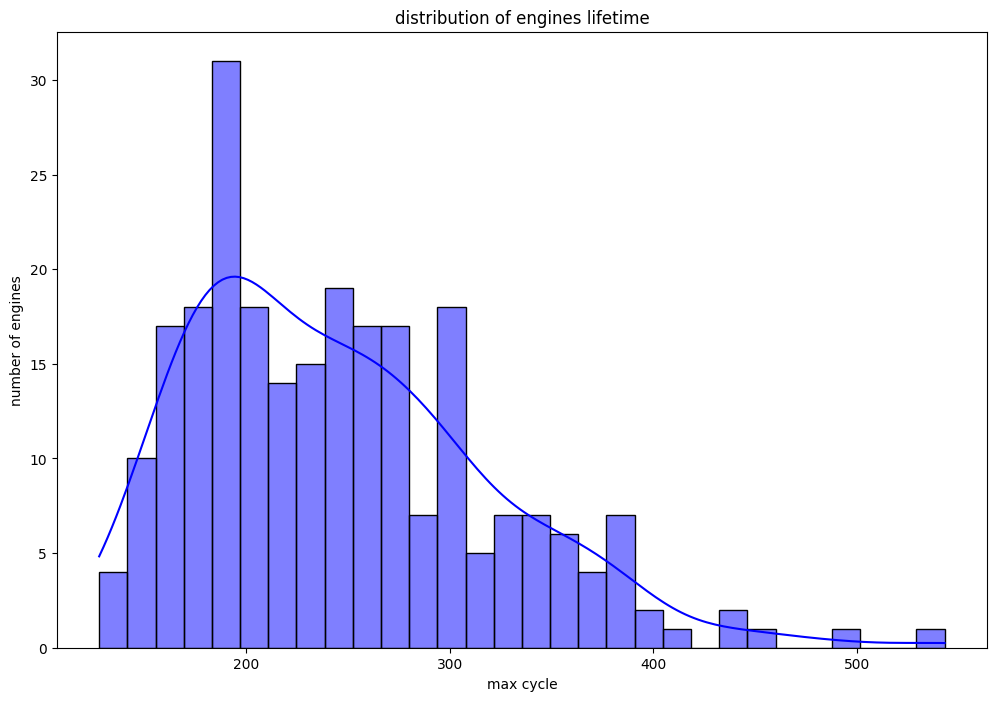

In [25]:
# engine life over time plot 

engine_life = train_df.groupby('engine_id')['cycle'].max()

plt.figure(figsize=(12, 8))
sns.histplot(engine_life, color='blue', bins=30, kde=True)
plt.xlabel("max cycle")
plt.ylabel("number of engines")
plt.title("distribution of engines lifetime")
plt.show()

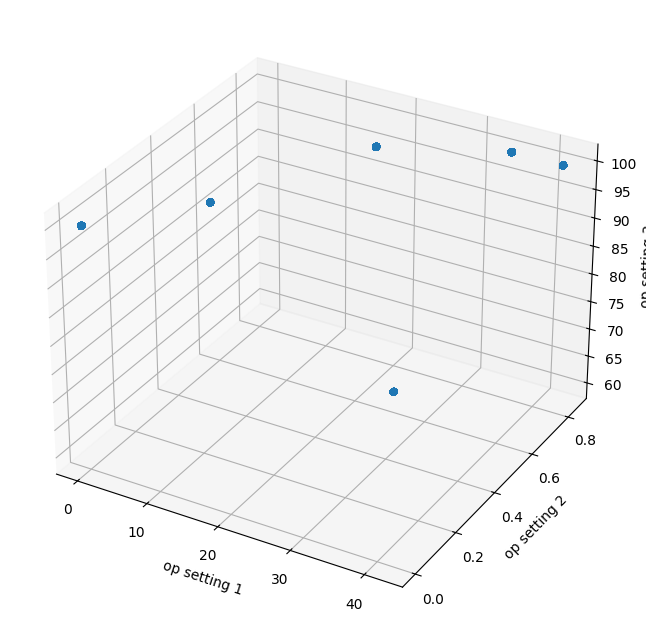

In [26]:
# op condition 3d plot 
# 6 clusters ---> looks like one cuz the values are very close to each other

fig = plt.figure(figsize=(12 ,8))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(
    train_df['op_setting_1'],
    train_df['op_setting_2'],
    train_df['op_setting_3'],
    alpha = 0.5
)

ax.set_xlabel("op setting 1")
ax.set_ylabel("op setting 2")
ax.set_zlabel("op setting 3")
plt.show()

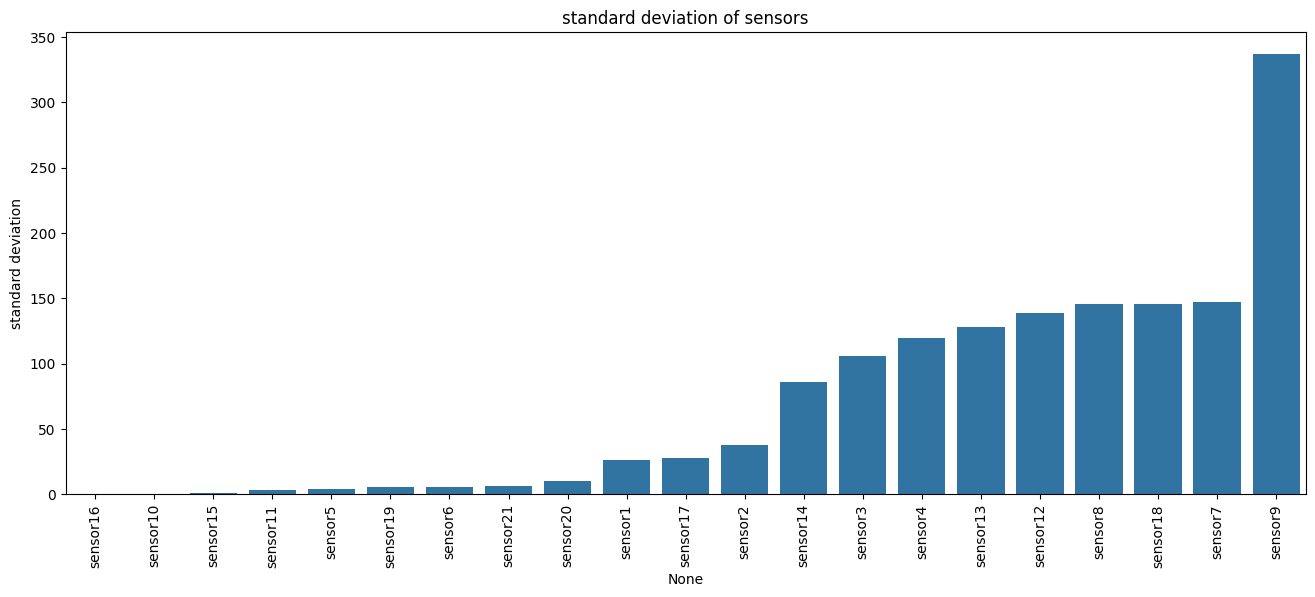

sensor16      0.004685
sensor10      0.127681
sensor15      0.750374
sensor11      3.243492
sensor5       3.622872
sensor19      5.369424
sensor6       5.444017
sensor21      5.962697
sensor20      9.936396
sensor1      26.436832
sensor17     27.808283
sensor2      37.342647
sensor14     85.670543
sensor3     106.167598
sensor4     119.327591
sensor13    128.197859
sensor12    138.479109
sensor8     145.348243
sensor18    145.472491
sensor7     146.880210
sensor9     336.927547
dtype: float64


In [27]:
# sensor variance plot (need to drop sensros with 0 var later)

sensor_cols = [f"sensor{i}" for i in range(1, 22)]
sensor_std = train_df[sensor_cols].std().sort_values()

plt.figure(figsize=(16, 6))
sns.barplot(x=sensor_std.index, y=sensor_std.values)
plt.title("standard deviation of sensors")
plt.xticks(rotation=90)
plt.ylabel("standard deviation")
plt.show()

print(sensor_std)

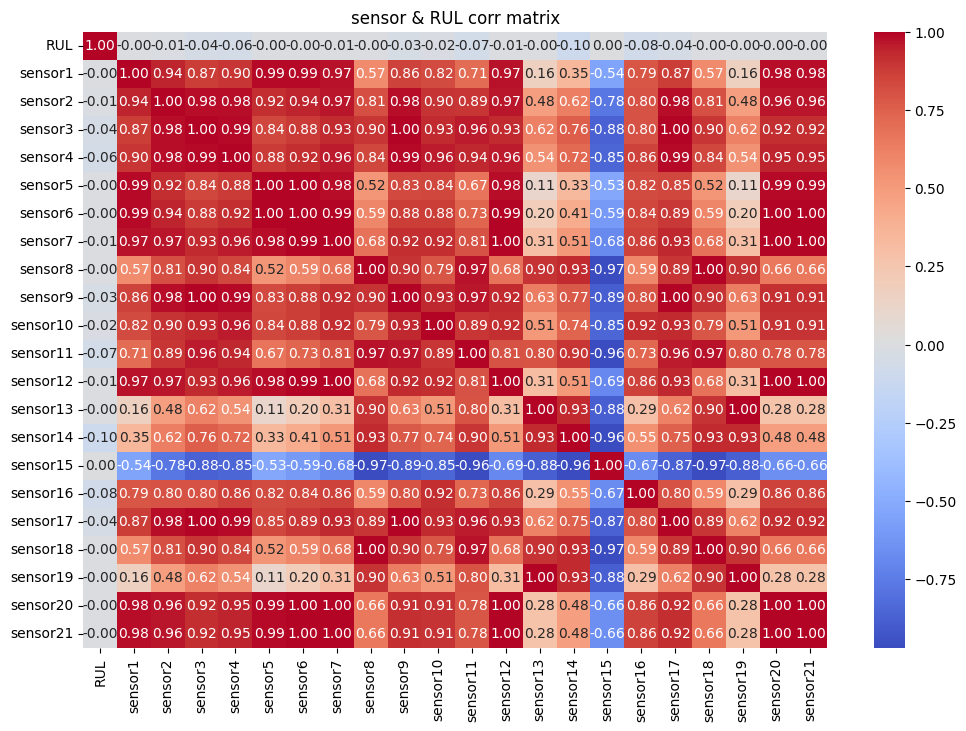

In [28]:
# RUL corr plot with sensros

corr_matrix = train_df[['RUL'] + sensor_cols].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True,fmt=".2f" , cmap="coolwarm")
plt.title("sensor & RUL corr matrix")
plt.show()

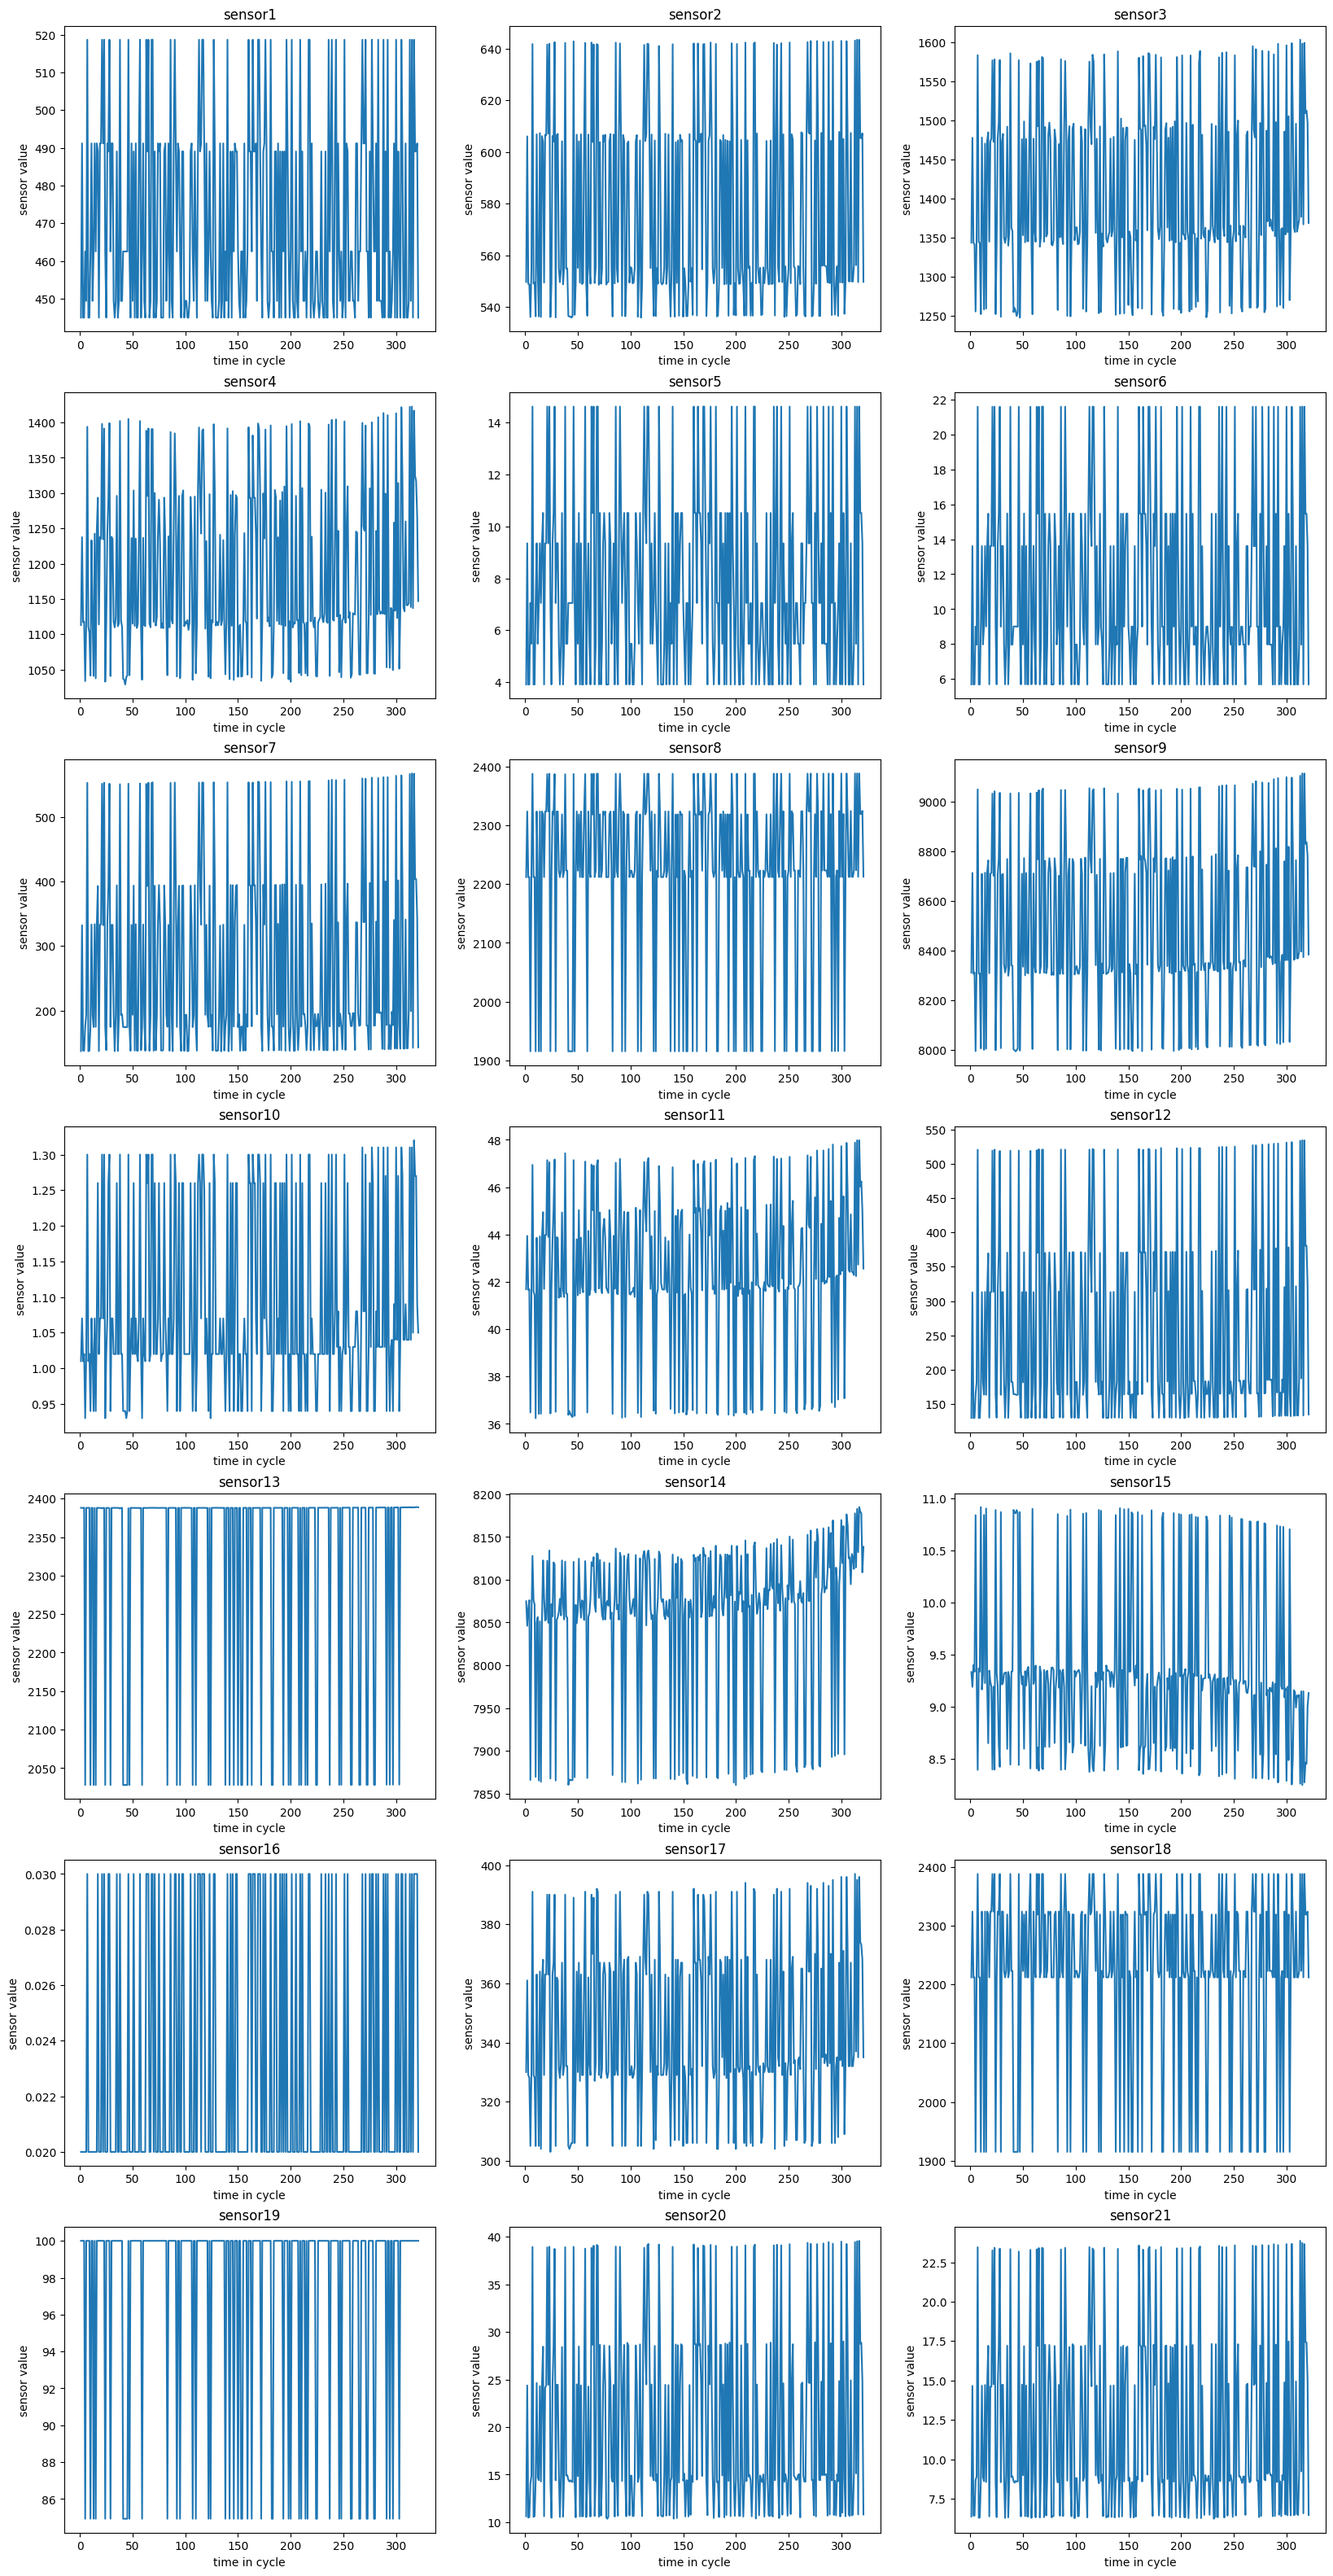

In [29]:
plt.figure(figsize=(20, 40))
for i in range(1, 22):
    plt.subplot(7, 3, i)
    plt.plot(train_df[train_df['engine_id'] == 1]['cycle'], 
             train_df[train_df['engine_id'] == 1][f'sensor{i}'])
    plt.title(f'sensor{i}')
    plt.xlabel("time in cycle")
    plt.ylabel('sensor value')
plt.show()

# Data Cleaning 

In [30]:
# dropping these sensors after analysis feature importance plot

index_to_drop = [18, 19, 1, 5, 16, 10, 7, 20, 21]
cols_to_drop = [f"sensor{i}" for i in index_to_drop]


train_df = train_df.drop(columns=cols_to_drop)
test_df = test_df.drop(columns=cols_to_drop)

# OP Clustering

In [31]:
# clustering settings ---> num of clusters were decided from the EDA

kmeans = KMeans(n_clusters=6, random_state=42)

op_cols = ['op_setting_1', 'op_setting_2', 'op_setting_3']

train_df['cluster'] = kmeans.fit_predict(train_df[op_cols])
test_df['cluster'] = kmeans.predict(test_df[op_cols])

In [32]:
# normalizing sensors relative to the 6 clusters

"""
sensors might show different numbers in each op setting so
we average value of a sensor (mean) and how much the sensos varies (std)

the z score shows how unusual this is 
when its 0 its normal but when it goes above and below its not normal
"""

remaining_sensors = [s for s in train_df.columns if s.startswith("sensor")]
nothing = 1e-8


for cluster_id in range(6):
    train_index = train_df['cluster'] == cluster_id
    test_index = test_df['cluster'] == cluster_id

    for col in remaining_sensors:
        mean = train_df.loc[train_index, col].mean()
        std = train_df.loc[train_index, col].std()

        # avoiding devision by 0
        if pd.isna(std) or std < nothing:
            std = 1.0
    
        # z score
        train_df.loc[train_index, col +  "_z"] = ((train_df.loc[train_index, col] - mean) / std)
        test_df.loc[test_index, col + "_z"]  = ((test_df.loc[test_index, col]  - mean) / std)

# Advanced Feature Engineering

In [33]:
# rolling median
train_group = train_df.groupby('engine_id')
test_group = test_df.groupby('engine_id')

for col in remaining_sensors:
    train_df[f"{col}_med"] = train_group[col].transform(
        lambda x : x.rolling(window=10, min_periods=1).median())
    test_df[f"{col}_med"] = test_group[col].transform(
        lambda x : x.rolling(window=10, min_periods=1).median())

# Data Prepration

In [34]:
X_train = train_df.drop(columns=['engine_id', 'RUL', 'cluster', 
                                 'op_setting_1', 'op_setting_2', 'op_setting_3'])
y_train = train_df['RUL']

X_test = test_df.groupby('engine_id').last().reset_index()
X_test = X_test.sort_values('engine_id')
X_test = X_test.drop(columns=['engine_id', 'cluster', 
                              'op_setting_1', 'op_setting_2', 'op_setting_3'])

In [35]:
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape:  {X_test.shape}")

X_train shape: (61249, 37)
X_test shape:  (248, 37)


# XGregressor Model Training 

In [36]:
param_grid = {
    'n_estimators': [300, 500, 1000],
    'learning_rate': [0.01, 0.03, 0.1],
    'max_depth': [3, 4, 5, 6],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.5, 0.6, 0.7, 0.8],
    'gamma': [0.1, 0.5],
    'min_child_weight': [5, 10]
}

In [37]:
# using kfold to avoid splitting 1 engine's rows between train and val (data leakage)
gkf = GroupKFold(n_splits=5)
cv = gkf
groups = train_df['engine_id']

In [38]:
# xgbregressor on GPU
xgb_reg = XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    device='cuda',
    tree_method='hist'
)

random_search = RandomizedSearchCV(
    estimator=xgb_reg,
    param_distributions=param_grid,
    n_iter=5,
    scoring='neg_root_mean_squared_error',
    cv=cv,
    verbose=2,
    n_jobs=1,
    random_state=42
).fit(X_train, y_train, groups=groups)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


/home/Goorba/miniconda3/envs/tf_gpu_py_3.11/lib/python3.11/site-packages/xgboost/core.py:774: UserWarning: [18:52:28] WARNING: /workspace/src/common/error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[CV] END colsample_bytree=0.7, gamma=0.5, learning_rate=0.01, max_depth=5, min_child_weight=10, n_estimators=300, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=0.7, gamma=0.5, learning_rate=0.01, max_depth=5, min_child_weight=10, n_estimators=300, subsample=0.8; total time=   1.0s
[CV] END colsample_bytree=0.7, gamma=0.5, learning_rate=0.01, max_depth=5, min_child_weight=10, n_estimators=300, subsample=0.8; total time=   0.9s
[CV] END colsample_bytree=0.7, gamma=0.5, learning_rate=0.01, max_depth=5, min_child_weight=10, n_estimators=300, subsample=0.8; total time=   0.9s
[CV] END colsample_bytree=0.7, gamma=0.5, learning_rate=0.01, max_depth=5, min_child_weight=10, n_estimators=300, subsample=0.8; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=300, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=300, su

In [39]:
best_model = random_search.best_estimator_

y_pred = best_model.predict(X_test)

rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse}")
print(f"R2: {r2}")

RMSE: 25.90898323059082
R2: 0.7741975784301758


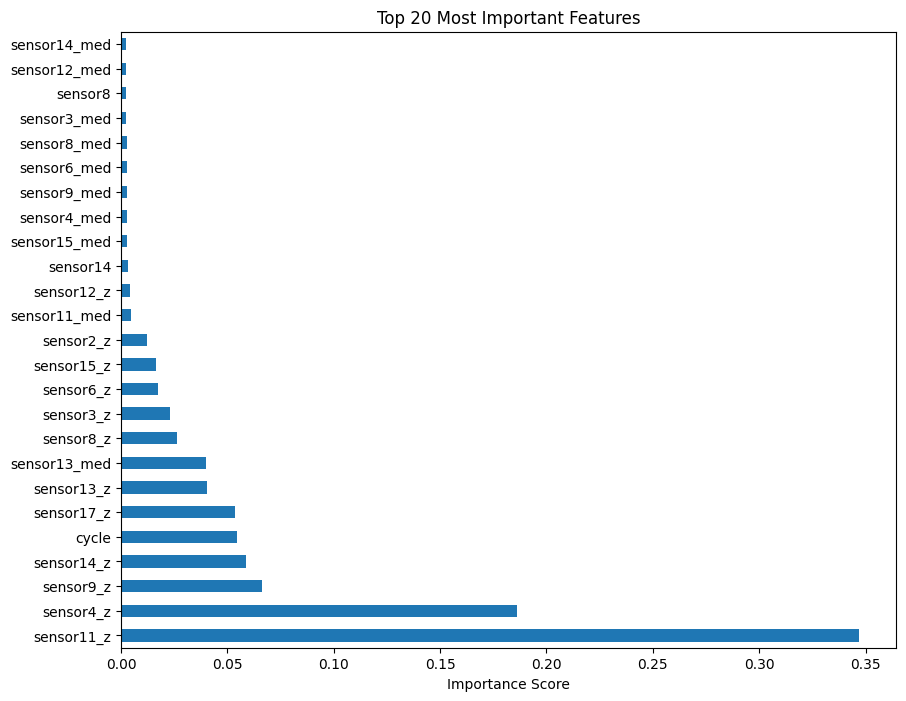

In [40]:
feature_names = X_train.columns
importances = best_model.feature_importances_ 
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)


plt.figure(figsize=(10, 8))
feat_imp.head(25).plot(kind='barh')
plt.title("Top 20 Most Important Features")
plt.xlabel("Importance Score")
plt.show()

In [41]:
print("Best params:", random_search.best_params_)

Best params: {'subsample': 0.8, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.8}
